<a href="https://colab.research.google.com/github/pinguksk109/COVID19-predict/blob/main/signate_covid19_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

In [40]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [41]:
#from google.colab import drive
#drive.mount('/content/drive')

In [42]:
#test = pd.read_csv("drive/My Drive/newdata/12月コンペデータ(1101-1207de)/test.csv")
#train = pd.read_csv("drive/My Drive/newdata/12月コンペデータ(1101-1207de)/train.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
display(test.tail(5))
#display(train.describe())

,ForecastID,Region,Date
1311,1312,Okinawa,2020-12-30
1312,1313,Okinawa,2020-12-31
1313,1314,Okinawa,2021-01-01
1314,1315,Okinawa,2021-01-02
1315,1316,Okinawa,2021-01-03


In [43]:
# test から 12/1 のレコードを削除する
# 12/1 を除く
#test = test[test.Date != '2020/12/1']
#test = test[test.Date != '2020/12/2']

In [44]:
print("Number of Region: ", train['Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")

Number of Region:  47
Dates go from day 2020-12-06 to day 2020-11-01 , a total of 36 days


Text(0.5, 0, 'Date')

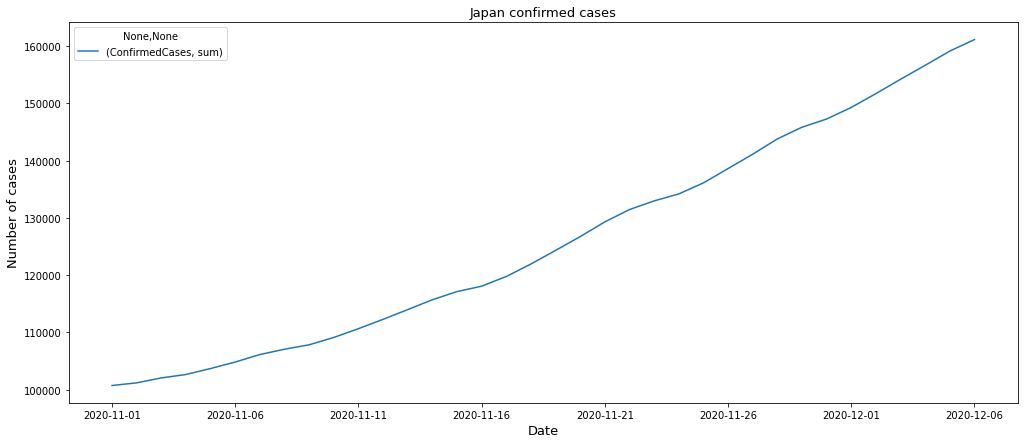

In [45]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date = confirmed_total_date

fig, (ax1) = plt.subplots(1, 1, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Japan confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

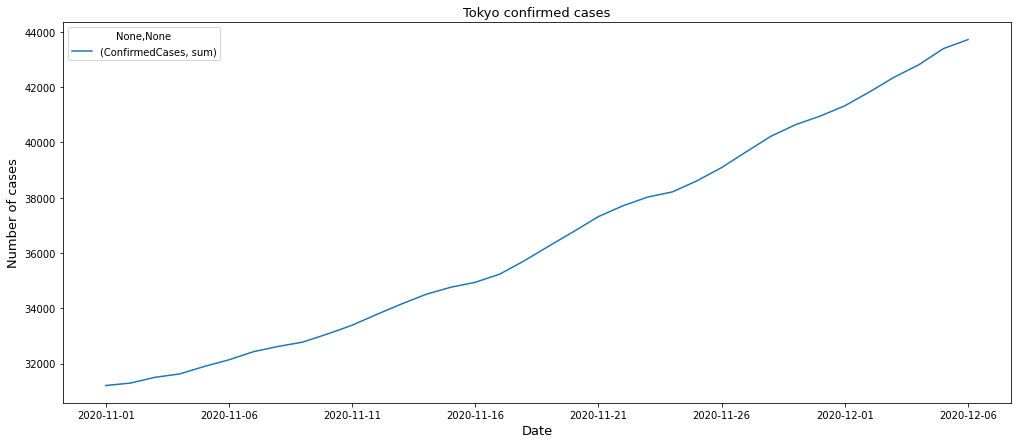

In [46]:
confirmed_total_date_Tokyo = train[train['Region']=='Tokyo'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Tokyo = confirmed_total_date_Tokyo

fig, (ax1) = plt.subplots(1, 1, figsize=(17,7))
total_date_Tokyo.plot(ax=ax1)
ax1.set_title("Tokyo confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

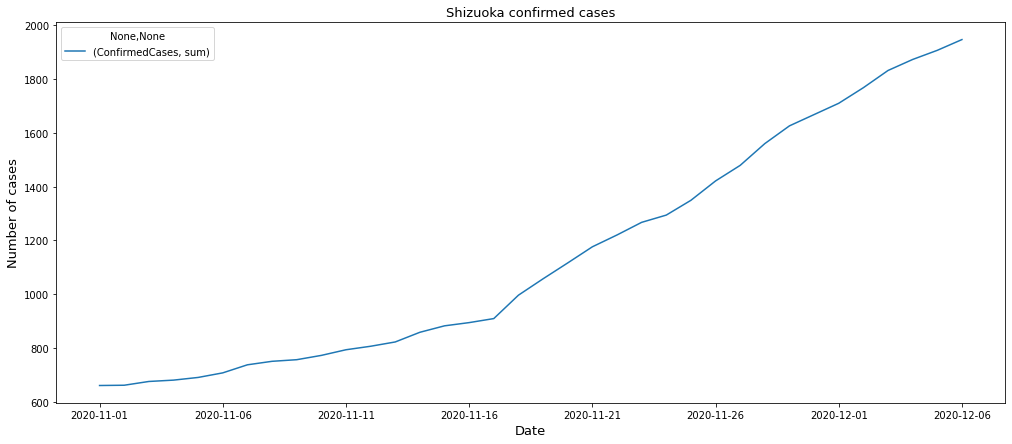

In [47]:
confirmed_total_date_Tokyo = train[train['Region']=='Shizuoka'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Tokyo = confirmed_total_date_Tokyo

fig, (ax1) = plt.subplots(1, 1, figsize=(17,7))
total_date_Tokyo.plot(ax=ax1)
ax1.set_title("Shizuoka confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

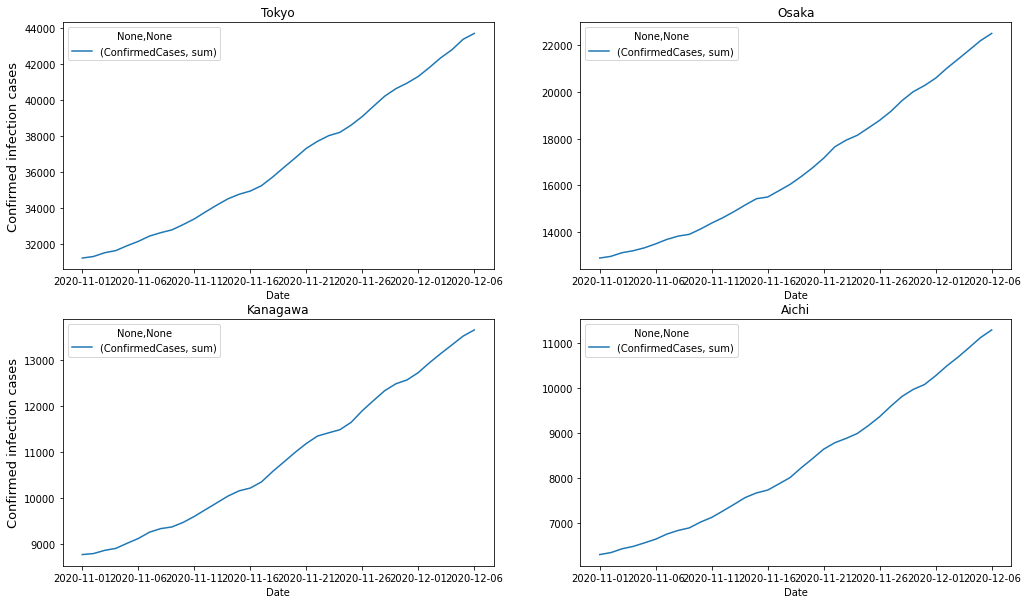

In [48]:
confirmed_total_date_Tokyo = train[train['Region']=='Tokyo'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Tokyo = confirmed_total_date_Tokyo

confirmed_total_date_Osaka = train[train['Region']=='Osaka'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Osaka = confirmed_total_date_Osaka

confirmed_total_date_Kanagawa = train[train['Region']=='Kanagawa'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Kanagawa = confirmed_total_date_Kanagawa

confirmed_total_date_Aichi = train[train['Region']=='Aichi'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Aichi = confirmed_total_date_Aichi

plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_Tokyo.plot(ax=plt.gca(), title='Tokyo')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Osaka.plot(ax=plt.gca(), title='Osaka')

plt.subplot(2, 2, 3)
total_date_Kanagawa.plot(ax=plt.gca(), title='Kanagawa')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Aichi.plot(ax=plt.gca(), title='Aichi')

(0.0, 0.05)

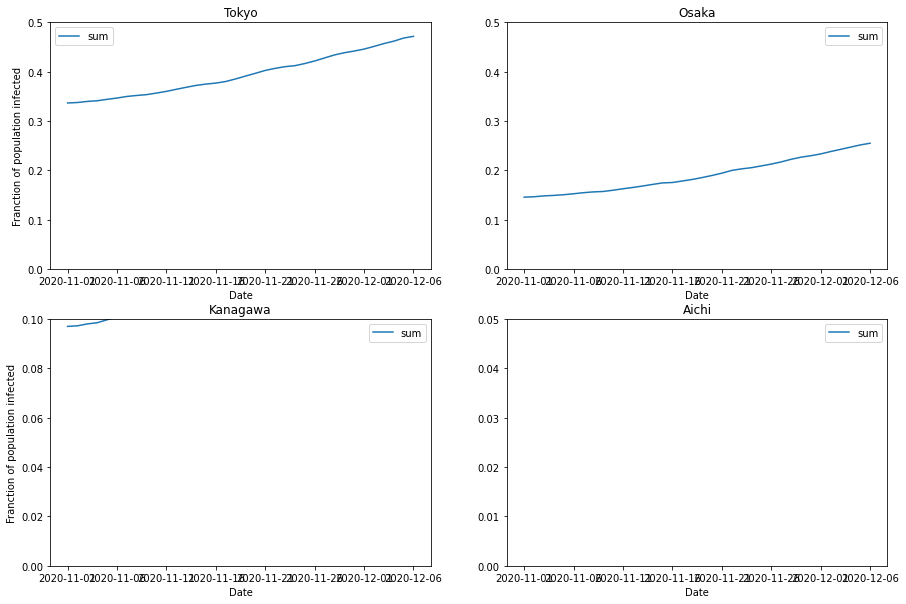

In [49]:
pop_tokyo = 9273000.
pop_osaka = 8823000.
pop_kanagawa = 9058000.
pop_aichi = 7553000.

total_date_Tokyo.ConfirmedCases = total_date_Tokyo.ConfirmedCases/pop_tokyo*100
total_date_Osaka.ConfirmedCases = total_date_Osaka.ConfirmedCases/pop_osaka*100
total_date_Kanagawa.ConfirmedCases = total_date_Kanagawa.ConfirmedCases/pop_kanagawa*100
total_date_Aichi.ConfirmedCases = total_date_Aichi.ConfirmedCases/pop_aichi*100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
total_date_Tokyo.ConfirmedCases.plot(ax=plt.gca(), title='Tokyo')
plt.ylabel("Franction of population infected")
plt.ylim(0, 0.5)

plt.subplot(2, 2, 2)
total_date_Osaka.ConfirmedCases.plot(ax=plt.gca(), title='Osaka')
plt.ylim(0, 0.5)

plt.subplot(2, 2, 3)
total_date_Kanagawa.ConfirmedCases.plot(ax=plt.gca(), title='Kanagawa')
plt.ylabel("Franction of population infected")
plt.ylim(0, 0.1)

plt.subplot(2, 2, 4)
total_date_Aichi.ConfirmedCases.plot(ax=plt.gca(), title='Aichi')
plt.ylim(0, 0.05)

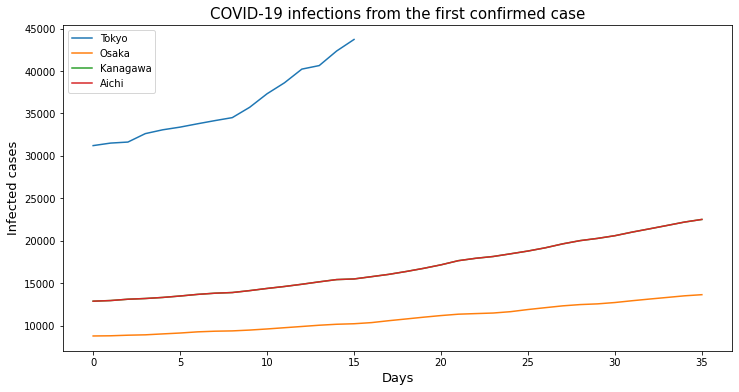

In [50]:
confirmed_total_date_Tokyo = train[(train['Region']=='Tokyo') & train['ConfirmedCases']!=0].groupby([('Date')]).agg({'ConfirmedCases':['sum']})
total_date_Tokyo = confirmed_total_date_Tokyo

confirmed_total_date_Kanagawa = train[(train['Region']=='Kanagawa') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Kanagawa = confirmed_total_date_Kanagawa

confirmed_total_date_Osaka = train[(train['Region']=='Osaka') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Osaka = confirmed_total_date_Osaka

confirmed_total_date_Aichi = train[(train['Region']=='Aichi') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_date_Aichi = confirmed_total_date_Aichi

tokyo = [i for i in total_date_Tokyo.ConfirmedCases['sum'].values]
tokyo_30 = tokyo[0:70]
kanagawa = [i for i in total_date_Kanagawa.ConfirmedCases['sum'].values]
kanagawa_30 = kanagawa[0:70]
osaka = [i for i in total_date_Osaka.ConfirmedCases['sum'].values]
osaka_30 = osaka[0:70]
aichi = [i for i in total_date_Aichi.ConfirmedCases['sum'].values]
aichi_30 = osaka[0:70]

plt.figure(figsize=(12, 6))
plt.plot(tokyo_30)
plt.plot(kanagawa_30)
plt.plot(osaka_30)
plt.plot(aichi_30)
plt.legend(["Tokyo", "Osaka", "Kanagawa", "Aichi"], loc="upper left")
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
#plt.ylim(0, 130000)
plt.show()

In [51]:
all_data = pd.concat([train, test], axis = 0, sort=False)

all_data['Date'] = pd.to_datetime(all_data['Date'])

#日付列を作成する
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

#traintestデータセットをマージした場合、null値を入力する
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['ID'].fillna(-1, inplace=True)
all_data['ForecastID'].fillna(-1, inplace=True)

display(all_data)
#display(all_data.loc[all_data['Date'] == '2020-11-04'])

,ID,Region,Date,ConfirmedCases,ForecastID,Day_num,Day,Month,Year
0,1.0,Hokkaido,2020-11-01,3205.0,-1.0,0,1,11,2020
1,2.0,Hokkaido,2020-11-02,3301.0,-1.0,1,2,11,2020
2,3.0,Hokkaido,2020-11-03,3372.0,-1.0,2,3,11,2020
3,4.0,Hokkaido,2020-11-04,3447.0,-1.0,3,4,11,2020
4,5.0,Hokkaido,2020-11-05,3566.0,-1.0,4,5,11,2020
...,...,...,...,...,...,...,...,...,...
1311,-1.0,Okinawa,2020-12-30,0.0,1312.0,59,30,12,2020
1312,-1.0,Okinawa,2020-12-31,0.0,1313.0,60,31,12,2020
1313,-1.0,Okinawa,2021-01-01,0.0,1314.0,61,1,1,2021
1314,-1.0,Okinawa,2021-01-02,0.0,1315.0,62,2,1,2021


In [52]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
ID              0
Region          0
Date            0
ConfirmedCases  0
ForecastID      0
Day_num         0
Day             0
Month           0
Year            0


In [53]:
#
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Region'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        #増減分を出している
        df[trend_column_lag] = (df.groupby(['Region'])[column].shift(0, fill_value=0) - df.groupby(['Region'])[column].shift(lag, fill_value=0))/df.groupby(['Region'])[column].shift(lag, fill_value=0.001)
    return df

ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1, 7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.22040462493896484


In [54]:
all_data[all_data['Region']=='Hokkaido'].iloc[290:300][['ID', 'Region', 'Date',
       'ConfirmedCases', 'ForecastID', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3']]

,ID,Region,Date,ConfirmedCases,ForecastID,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3


In [55]:
print("Encoded dataset")
all_data['Region'] = le.fit_transform(all_data['Region'])
number_c = all_data['Region']
countries = le.inverse_transform(all_data['Region'])
region_dict = dict(zip(countries, number_c))
display(all_data)

Encoded dataset


,index,ID,Region,Date,ConfirmedCases,ForecastID,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6
0,0,1.0,8,2020-11-01,3205.0,-1.0,0,1,11,2020,0.0,0.0,0.0,0.0,0.0,0.0,3.205000e+06,3.205000e+06,3.205000e+06,3.205000e+06,3205000.0,3205000.0
1,1,2.0,8,2020-11-02,3301.0,-1.0,1,2,11,2020,3205.0,0.0,0.0,0.0,0.0,0.0,2.995320e-02,3.301000e+06,3.301000e+06,3.301000e+06,3301000.0,3301000.0
2,2,3.0,8,2020-11-03,3372.0,-1.0,2,3,11,2020,3301.0,3205.0,0.0,0.0,0.0,0.0,2.150863e-02,5.210608e-02,3.372000e+06,3.372000e+06,3372000.0,3372000.0
3,3,4.0,8,2020-11-04,3447.0,-1.0,3,4,11,2020,3372.0,3301.0,3205.0,0.0,0.0,0.0,2.224199e-02,4.422902e-02,7.550702e-02,3.447000e+06,3447000.0,3447000.0
4,4,5.0,8,2020-11-05,3566.0,-1.0,4,5,11,2020,3447.0,3372.0,3301.0,3205.0,0.0,0.0,3.452277e-02,5.753262e-02,8.027870e-02,1.126365e-01,3566000.0,3566000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,1311,-1.0,30,2020-12-30,0.0,1312.0,59,30,12,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
3004,1312,-1.0,30,2020-12-31,0.0,1313.0,60,31,12,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
3005,1313,-1.0,30,2021-01-01,0.0,1314.0,61,1,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
3006,1314,-1.0,30,2021-01-02,0.0,1315.0,62,2,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


Text(0, 0.5, 'Log ConfirmedCases')

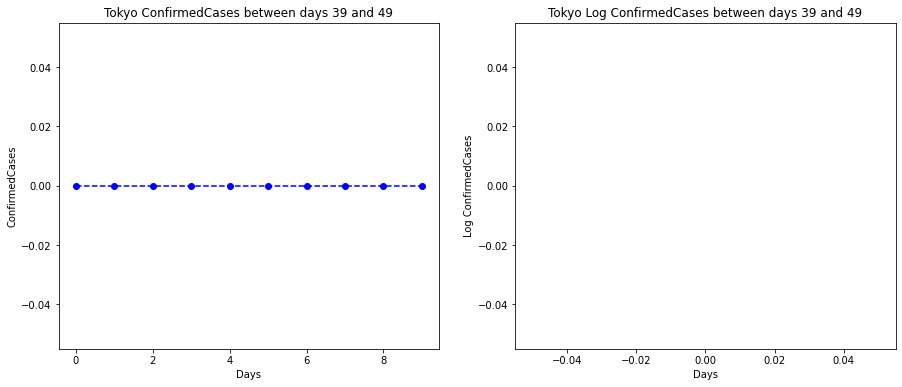

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

#Day_num=38は3月1日
y1 = all_data[(all_data['Region']==region_dict['Tokyo']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Tokyo ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Region']==region_dict['Tokyo']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Tokyo Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [57]:
#選択した機能をフィルタリングする
data = all_data.copy()
features = ['ID', 'ForecastID', 'Region', 'ConfirmedCases', 'Day_num']
data = data[features]

#トレンドを除くすべてのConfirmedCases列にログ変換を適用します
data['ConfirmedCases'] = data['ConfirmedCases'].astype('float64')
data['Confirmedcases'] = data['ConfirmedCases'].apply(lambda x: np.log1p(x))

#無限大を置き換える
data.replace([np.inf, -np.inf], 0, inplace=True)

#データをtrain/testに分割
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim, 'ForecastID'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train set
    x_train = df[df.ForecastID == -1].drop(['ConfirmedCases'], axis=1)
    y_train_1 = df[df.ForecastID == -1]['ConfirmedCases']
    
    #test set
    x_test = df[df.ForecastID != -1].drop(['ConfirmedCases'], axis=1)
    
    #Id列をクリーンアップし、ForecastIdをインデックスとして保持します
    x_train.drop('ID', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastID', inplace=True, erroes='ignore', axis=1)
    x_test.drop('ID', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastID', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test

#線形回帰モデル
def lin_reg(X_train, Y_train, X_test):
    #線形回帰オブジェクトを作成する
    regr = linear_model.LinearRegression()
    
    #トレーニングセットを使用してモデルをトレーニングします
    regr.fit(X_train, Y_train)
    
    #テストセットを使用して予測を行う
    y_pred = regr.predict(X_test)
    
    return regr, y_pred

#提出機能
def get_submission(df, target1):
    
    prediction_1 = df[target1]
    
    #予測を送信する
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    
    submission = pd.DataFrame({
        "ForecastID": df['ForecastID'].astype('int32'), 
        "ConfirmedCases": prediction_1,
    })
    submission.to_csv("submission.csv", index=False)

In [58]:
#ロジスティック回帰！

#ロジスティック関数　
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data, region_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Region']==region_dict[region_name])]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))
    
    #最初の推測　a0 b1 c1 d0
    p0 = [0,1,1,0]
    
    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, region_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on January 22nd)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ region_name)
    
def plot_logistic_country(all_data, train, region_name, valid_num, target, x, a_, b_, c_, d_):
    forecast = logistic_function(list(range(len(x)+60)), a_, b_, c_, d_)
    df_train = train.loc[(train['Region']==region_name), target]
    #print(len(df_train))
    df_fcst = forecast[:len(df_train)]
    dates = list(range(0, len(df_train)))
    
    #plot results
    fig1, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    #ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls=':', color='grey', alpha=0.5)
    ax1.axvline(valid_num, linewidth=2, ls=':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on Logistic curve for "+region_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on December 7nd")
    ax1.set_ylabel("ConfirmedCases")  

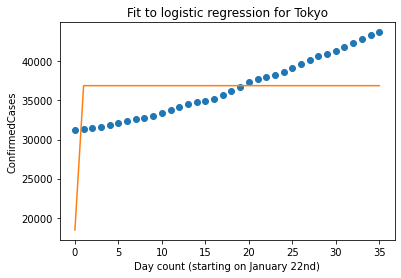

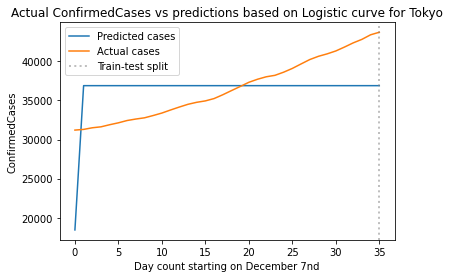

In [59]:
#東京をロジスティック曲線にフィッチングさせる
region_name = 'Tokyo'
train_lim = 35 #??
#valid_lim = 49 #OK! #より多くの日数のトレーニングデータが含まれているため、変更する必要がある 最初の上のやつ
#test_lim = 71 #途中のデータから
#valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, region_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, region_name, 'ConfirmedCases')
#plot_logistic_country(all_data, train, region_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)
plot_logistic_country(all_data, train, region_name, train_lim, 'ConfirmedCases', x, a_, b_, c_, d_)

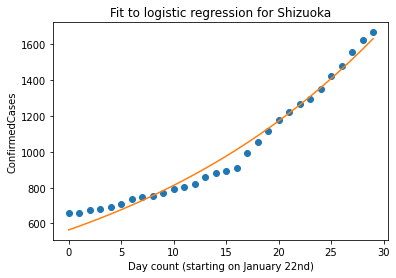

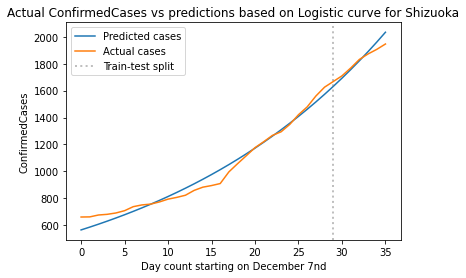

In [60]:
#東京をロジスティック曲線にフィッチングさせる
region_name = 'Shizuoka'
train_lim = 29 #??
#valid_lim = 49 #OK! #より多くの日数のトレーニングデータが含まれているため、変更する必要がある 最初の上のやつ
#test_lim = 71 #途中のデータから
#valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, region_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, region_name, 'ConfirmedCases')
#plot_logistic_country(all_data, train, region_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)
plot_logistic_country(all_data, train, region_name, train_lim, 'ConfirmedCases', x, a_, b_, c_, d_)

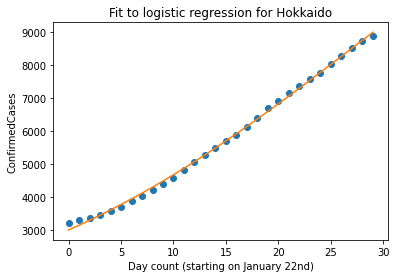

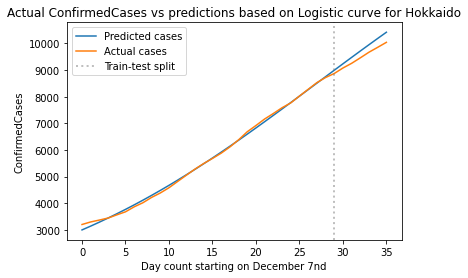

In [61]:
#東京をロジスティック曲線にフィッチングさせる
region_name = 'Hokkaido'
train_lim = 29 #??
#valid_lim = 49 #OK! #より多くの日数のトレーニングデータが含まれているため、変更する必要がある 最初の上のやつ
#test_lim = 71 #途中のデータから
#valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, region_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, region_name, 'ConfirmedCases')
#plot_logistic_country(all_data, train, region_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)
plot_logistic_country(all_data, train, region_name, train_lim, 'ConfirmedCases', x, a_, b_, c_, d_)

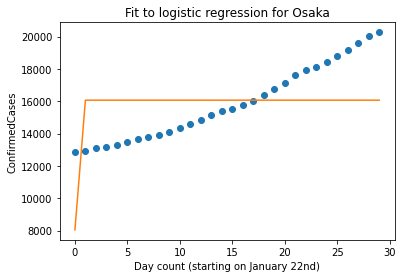

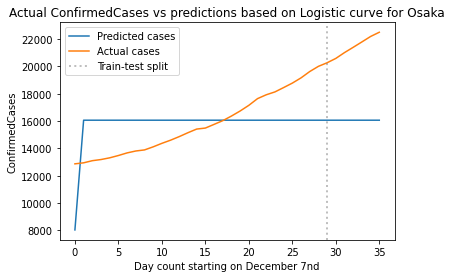

In [62]:
#東京をロジスティック曲線にフィッチングさせる
region_name = 'Osaka'
train_lim = 29 #??
#valid_lim = 49 #OK! #より多くの日数のトレーニングデータが含まれているため、変更する必要がある 最初の上のやつ
#test_lim = 71 #途中のデータから
#valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, region_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, region_name, 'ConfirmedCases')
#plot_logistic_country(all_data, train, region_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)
plot_logistic_country(all_data, train, region_name, train_lim, 'ConfirmedCases', x, a_, b_, c_, d_)

In [63]:
train_lim = 35 #??
test_lim = 63 #OK!

def logistic_forecast_allcountries(all_data, train, train_lim, test_lim):
    
    ts = time.time()
    data_pred = all_data[all_data.ForecastID != -1][['Region', 'Day_num', 'ForecastID']]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    
    #Main loop for countries
    for region_name in train['Region'].unique():
        
        #ConfirmedCases
        x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, region_name, train_lim, 'ConfirmedCases')
        pred_1 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
        data_pred.loc[(data_pred['Region']==region_dict[region_name]), 'Predicted_ConfirmedCases'] = pred_1
        
    print("Logistic function fit for all region finished in ", round(time.time() - ts, 2), " seconds")
    return data_pred

logistic_forecast = logistic_forecast_allcountries(all_data, train, train_lim, test_lim)
get_submission(logistic_forecast, 'Predicted_ConfirmedCases')

Logistic function fit for all region finished in  7.16  seconds


In [71]:
#!pip install pyramid.arima
#from pyramid.arima import auto_arima
!pip install pmdarima
from pmdarima import auto_arima

In [72]:
#arimaで使う関数を実装
def arima_cp(all_data, region_name, target, train_lim, test_lim):
  data_cp = all_data.loc[(all_data['Region']==region_dict[region_name])]
  data_cp_train = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
  data_cp_test = data_cp.loc[(data_cp['Day_num'])>test_lim, target].astype(np.int32)

  #使用するパラメータの範囲を設定する
  stepwise_model = auto_arima(data_cp[target], start_p=1, start_q=1, max_p=30, max_q=30, start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)
  
  #トレーニングと予測
  stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
  forecast = stepwise_model.predict(n_periods=test_lim-train_lim)
  return forecast

In [73]:
#実際の値と予測をプロット
def plot_arima_country(all_data, train, forecast, region_name, valid_num, target):
    df_train = train.loc[(train['Region']==region_name), target]
    df_fcst = np.append(df_train[:-valid_num], forecast[:valid_num])
    #df_fcst = np.append(train[:valid_lim], forecast)
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+region_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on January 22nd")
    ax1.set_ylabel("ConfirmedCases")

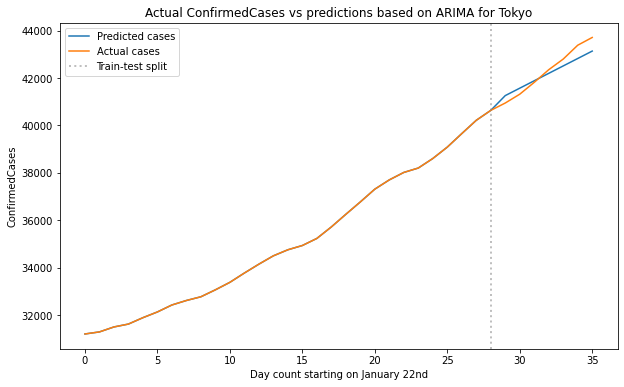

In [74]:
train_lim = 29 #予測スタート日
valid_lim = 36 #固定
test_lim = 71
valid_num=valid_lim-train_lim

#inputs
region_name = 'Tokyo'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

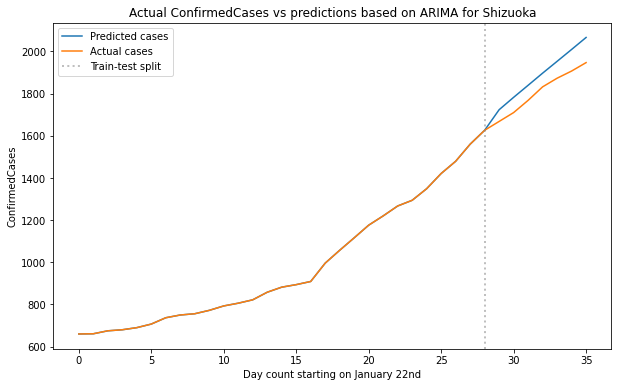

In [75]:
train_lim = 29 #予測スタート日
valid_lim = 36 #固定
test_lim = 71
valid_num=valid_lim-train_lim

#inputs
region_name = 'Shizuoka'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

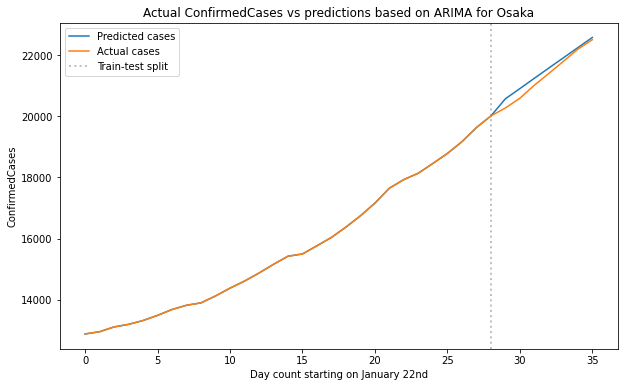

In [76]:
train_lim = 29 #予測スタート日
valid_lim = 36 #固定
test_lim = 71
valid_num=valid_lim-train_lim

#inputs
region_name = 'Osaka'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

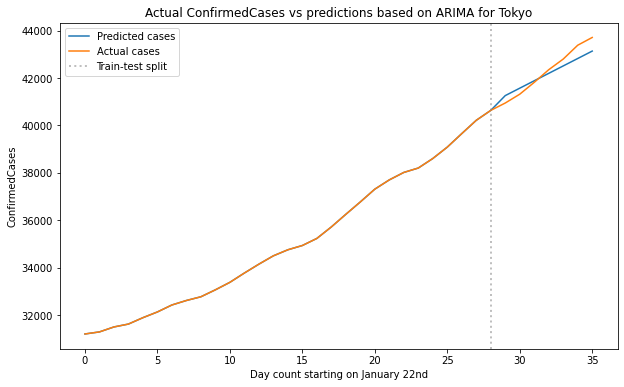

In [77]:
#inputs
region_name = 'Tokyo'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

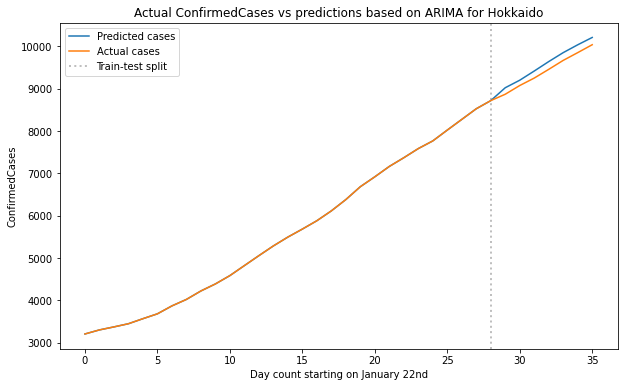

In [78]:
#inputs
region_name = 'Hokkaido'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

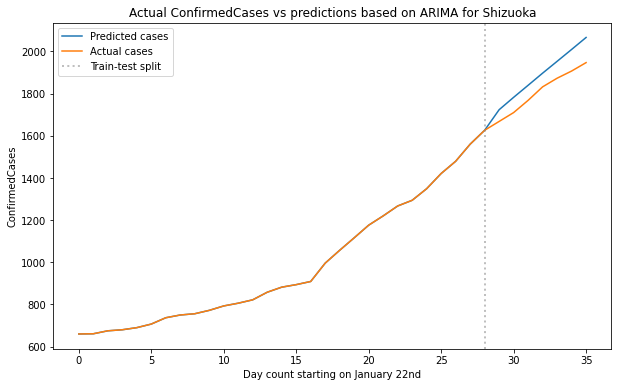

In [79]:
#inputs
region_name = 'Shizuoka'

forecast = arima_cp(all_data, region_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, region_name, valid_num, 'ConfirmedCases')

In [80]:
train_lim = 35 #??
test_lim = 63 #OK!

def arima_forecast_allcountries(all_data, train, train_lim, test_lim):

  ts = time.time()
  ARIMA_forecast = all_data[all_data.ForecastID != -1][['Region', 'Day_num', 'ForecastID']]
  ARIMA_forecast['Predicted_ConfirmedCases'] = [0]*len(ARIMA_forecast)

  for c in train['Region'].unique():
            #print(c)
            pred_1 = arima_cp(all_data, c, 'ConfirmedCases', train_lim, test_lim)
            ARIMA_forecast.loc[((ARIMA_forecast['Region']==region_dict[c])), 'Predicted_ConfirmedCases'] = pred_1

  print("arima function fit for all region finished in ", round(time.time() - ts, 2), " seconds")
  return ARIMA_forecast

arima_forecast = arima_forecast_allcountries(all_data, train, train_lim, test_lim)
get_submission(arima_forecast, 'Predicted_ConfirmedCases')  

arima function fit for all region finished in  119.95  seconds
